In [83]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
from chinese_calendar import is_workday, is_holiday
import chinese_calendar as calendar
import time, datetime
from  tqdm import tqdm
import numba
from numba import jit
warnings.filterwarnings('ignore')
text = pd.read_csv("PRSA_data.csv",encoding='unicode_escape').convert_dtypes()
text.isnull().sum()

No          0
year        0
month       0
day         0
hour        0
pm2.5    2067
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64

In [84]:
#preprocess:

#1.feature genertating
#
# text['time'] = text.apply(lambda x : datetime.datetime(year=x['year'], month=x['month'], day=x['day'], hour=x['hour']), axis=1)
# text = text.set_index('time')


#北风强度值
def transform_north(x):
    if(x.cbwd=='NE' or x.cbwd=='NW'):
        return x.Iws
    else: return 0

text['N_E'] = text.apply(lambda x: transform_north(x),axis=1 )


def transform_four_period(x):
    if(0<=x and x<=6): return 'night'
    elif(x<=12): return 'morning'
    elif(x<=18): return 'afternoon'
    else :return 'evening'
text['period'] = text.apply(lambda x: transform_four_period(x.hour),axis=1 )

#spring, summer, fall, winter

def transform_four_season(x):
    if(3<=x and x<=5): return 'spring'
    elif(x<=8): return 'summer'
    elif(x<=10): return 'fall'
    else :return 'winter'
text['season'] = text.apply(lambda x: transform_four_season(x.month),axis=1 )

#the week (weekdays, weekends, or holidays)
def transform_four_Week(year,month,day):
    now_date = datetime.date(year, month, day)
    on_holiday, holiday_name = calendar.get_holiday_detail(now_date)
    if(on_holiday): return 'weekends' if holiday_name is None else 'holiday'
    elif(is_workday(now_date)):return 'workday'
    else: return 'weekends'
text['Week'] = text.apply(lambda x: transform_four_Week(x.year,x.month,x.day),axis=1 )



def norm_to_float(c):
    element = text[c].unique()
    dictionary = dict(zip(element,range(0,len(element)))) #反转
    text[c] = text.apply(lambda x:dictionary[x[c]],axis=1)
    return dictionary
dict_period = norm_to_float('period')
dict_season = norm_to_float('season')
dict_Week = norm_to_float('Week')
# dict_PM2_5 = norm_to_float('pm2.5')





def transform_four_segment(x):
    if(8<=x and x<=9): return 'Morning_rush '
    elif(x<=17): return 'Work'
    elif(x<=19): return 'Evening_rush'
    else :return 'Home'
text['segment'] = text.apply(lambda x: transform_four_period(x.hour),axis=1 )
dict_Segment = norm_to_float('segment')


text['diff'] = text['DEWP']-text['N_E']

from sklearn.decomposition import PCA
pca  = PCA(n_components=1)
text['composition'] = pca.fit_transform(list(zip(text['DEWP'],-text['N_E'])))



text['cbwd'].unique()
text = text.join(pd.get_dummies(text['cbwd']).astype('float'))
del text['cbwd']

#2.processing the missing value
#from the segment3 ,this is the best choice :fill with mean
#We using the text to fillin to simplify ; The right way is to fill in with Train_set
text=text.fillna(int(text['pm2.5'].mean()))

In [ ]:

#该函数的作用是探索某个变量对pm2.5的影响

def Examine(features):
    features_condition = text.groupby([features])
    value_of_feature = features_condition['pm2.5'].mean()
    value_of_feature.plot()



In [86]:
def generate_dataset(data):
    #先划分数据集
    Train_set=pd.DataFrame(columns=text.columns)
    Test_set=pd.DataFrame(columns=text.columns)
    text_data =data.groupby(['year','month','day'])
    for index,(name,data)  in enumerate(text_data):
        if((index+1)%7 ==0):
            Test_set =Test_set.append(data)
        else:
            Train_set = Train_set.append(data)

    return Train_set,Test_set
Train_set,Test_set = generate_dataset(text)



In [ ]:
engineer_set = text.copy()

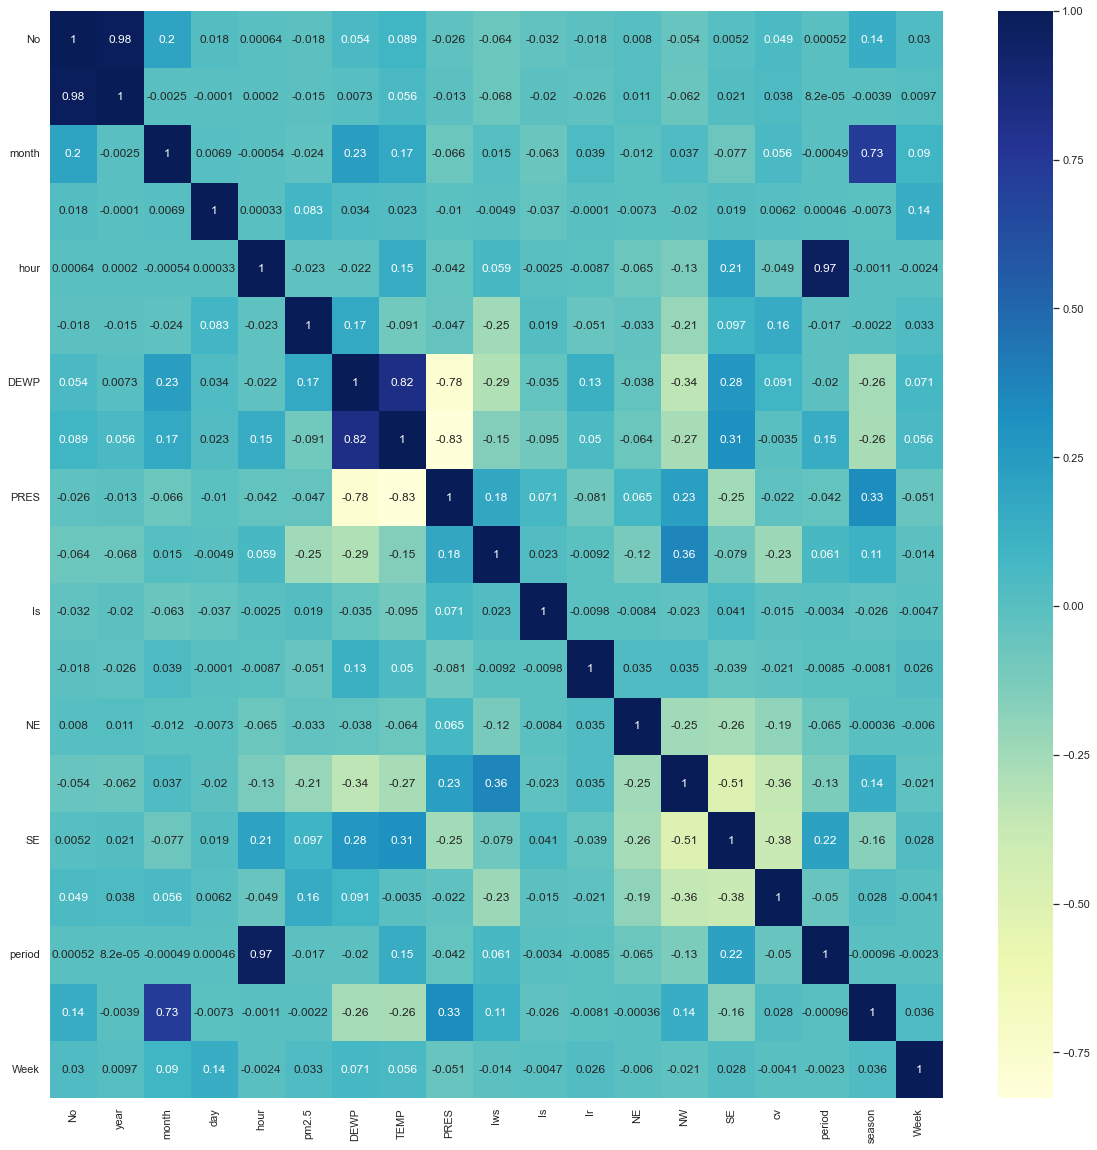

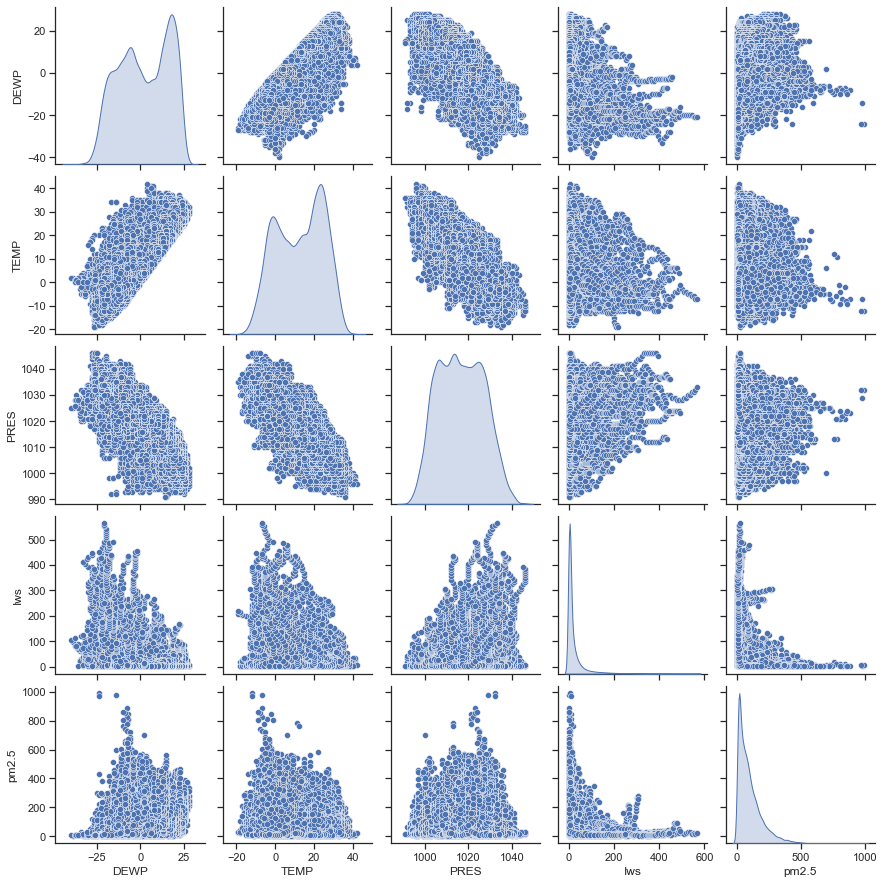

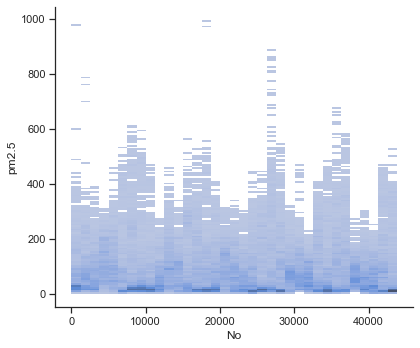

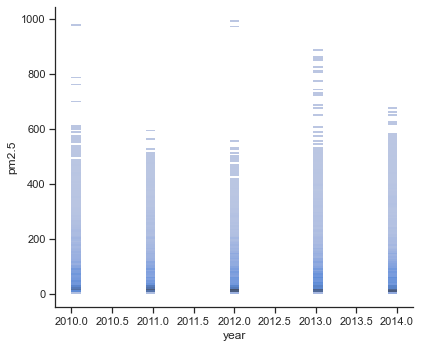

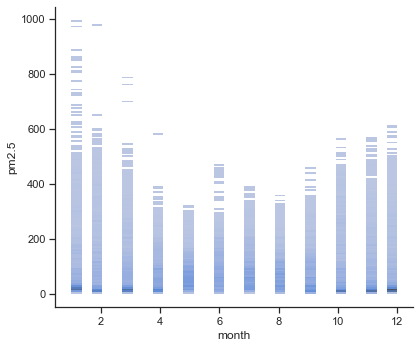

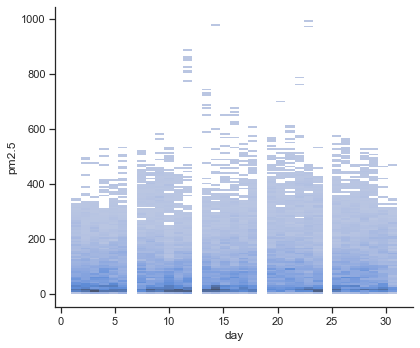

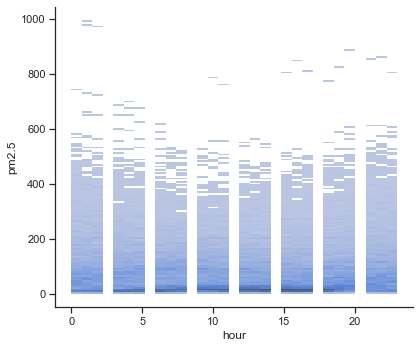

In [77]:

#Draw
import seaborn as sns
#进行特征工程
engineer_set = engineer_set.dropna()
ax = sns.heatmap(engineer_set.corr(), annot=True, cmap="YlGnBu")
ax.figure.set_size_inches(20,20)

import seaborn as sns

sns.set(style="ticks", color_codes=True)
# 创建自定义颜色调色板
palette = sns.xkcd_palette(['dark blue', 'dark green', 'gold', 'orange'])

# 画散点图矩阵
# sns.pairplot(engineer_set, kind = 'reg',diag_kind = 'kde')
sns.pairplot(engineer_set,diag_kind = 'kde')
plt.show()

sns.displot(engineer_set,y ='pm2.5',kind='hist',x= 'No', aspect=1.2)
sns.displot(engineer_set,y ='pm2.5',kind='hist',x= 'year', aspect=1.2)
sns.displot(engineer_set,y ='pm2.5',kind='hist',x= 'month', aspect=1.2)
sns.displot(engineer_set,y ='pm2.5',kind='hist',x= 'day', aspect=1.2)
sns.displot(engineer_set,y ='pm2.5',kind='hist',x= 'hour', aspect=1.2)
plt.show()

In [87]:
from sklearn.utils import shuffle
Train_set = shuffle(Train_set)
Test_set = shuffle(Test_set)
X_train = Train_set.astype('float')
Y_train  = X_train.pop('pm2.5')
X_test =Test_set.astype('float')
Y_test =X_test.pop('pm2.5')


In [88]:
from xgboost import XGBRegressor
model = XGBRegressor( objective='reg:linear',
                      colsample_bytree=0.3,
                      learning_rate=0.1,
                      max_depth=5,
                      n_estimators=3000,
                      alpha=10)
model.fit(X_train,Y_train)
score = model.score(X_test,Y_test)
print(score)




[05:52:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-3.8/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
0.72773483881071


In [ ]:
from sklearn.feature_selection import SelectKBest
from minepy import MINE
#由于MINE的设计不是函数式的，定义mic方法将其为函数式的，返回一个二元组，二元组的第2项设置成固定的P值0.5
def mic(x, y):
    m = MINE()
    m.compute_score(x, y)
    return (m.mic(), 0.5)
# 选择K个最好的特征，返回特征选择后的数据
func_mic = lambda X,y: list(np.array([mic(x,y) for x in X.T]).T)

X_filtered_MIC = SelectKBest(func_mic,k = 8).fit(X_train.values,Y_train)

In [88]:
new_text =text.copy()

In [92]:

Train_set,Test_set = generate_dataset(new_text)
def get_score(trainset,testset):
    trainset =trainset.astype("float")
    testset =testset.astype("float")
    train_set=trainset.copy()
    test_set=testset.copy()
    Y_train =train_set['pm2.5']
    Y_test =test_set['pm2.5']
    del train_set['pm2.5']
    del test_set['pm2.5']
    X_train = train_set
    X_test =test_set

    model = XGBRegressor()
    model.fit(X_train,Y_train)
    score = model.score(X_test,Y_test)
    return score
get_score(Train_set,Test_set)




0.6900197919911977